# Examples of how to load models, make predictions, and analyze predictions on validation set

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm

from nanopore_dataset import create_sample_map
from nanopore_dataset import create_splits
from nanopore_dataset import load_csv
from nanopore_dataset import NanoporeDataset

from resnet1d import ResNet1D

In [132]:
# Set Device
device = 'cuda:0' # Use 'cpu' for cpu

In [49]:
# Create resnet model
model = ResNet1D(
            in_channels=1,
            base_filters=128,
            kernel_size=3,
            stride=2,
            groups=1,
            n_block=8,
            n_classes=2,
            downsample_gap=2,
            increasefilter_gap=4,
            use_do=False)
summary(model, (1, 400), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 400]             512
   MyConv1dPadSame-2             [-1, 128, 400]               0
       BatchNorm1d-3             [-1, 128, 400]             256
              ReLU-4             [-1, 128, 400]               0
            Conv1d-5             [-1, 128, 400]          49,280
   MyConv1dPadSame-6             [-1, 128, 400]               0
       BatchNorm1d-7             [-1, 128, 400]             256
              ReLU-8             [-1, 128, 400]               0
            Conv1d-9             [-1, 128, 400]          49,280
  MyConv1dPadSame-10             [-1, 128, 400]               0
       BasicBlock-11             [-1, 128, 400]               0
      BatchNorm1d-12             [-1, 128, 400]             256
             ReLU-13             [-1, 128, 400]               0
           Conv1d-14             [-1, 1

In [176]:
# Load saved weights

MESMLR_FN = 'best_models/mesmlr_resnet1d.pt'
ADDSEQ_FN = 'best_models/addseq_resnet1d.pt'

weights_path = MESMLR_FN

model.load_state_dict(torch.load(weights_path))
model.to(device)
model.eval() # Put model in inference mode

ResNet1D(
  (first_block_conv): MyConv1dPadSame(
    (conv): Conv1d(1, 128, kernel_size=(3,), stride=(1,))
  )
  (first_block_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_block_relu): ReLU()
  (basicblock_list): ModuleList(
    (0): BasicBlock(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.5, inplace=False)
      (conv1): MyConv1dPadSame(
        (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      )
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (do2): Dropout(p=0.5, inplace=False)
      (conv2): MyConv1dPadSame(
        (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      )
      (max_pool): MyMaxPool1dPadSame(
        (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): BasicBlock(
      (bn1)

## Make some predictions

In [178]:
# Make predictions on random sequeces
mean = torch.zeros((1, 1, 400)) + 90 # Mean of raw data
std = torch.zeros((1, 1, 400)) + 40 # Spread of raw data
for i in range(10):
    dummy_sequence = torch.normal(mean, std).to(device)
    prediction = model(dummy_sequence).sigmoid().round().item()
    print(prediction)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


102648it [00:00, 829493.36it/s]


[77.8549, 102.026, 102.026, 66.589, 64.7454, 64.1309, 62.6971, 63.5164, 66.9986, 61.8778]
tensor([ 77.8549, 102.0260, 102.0260,  66.5890,  64.7454,  64.1309,  62.6971,
         63.5164,  66.9986,  61.8778])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 266.35it/s]


Text(0, 0.5, 'Predicted "Probability"')

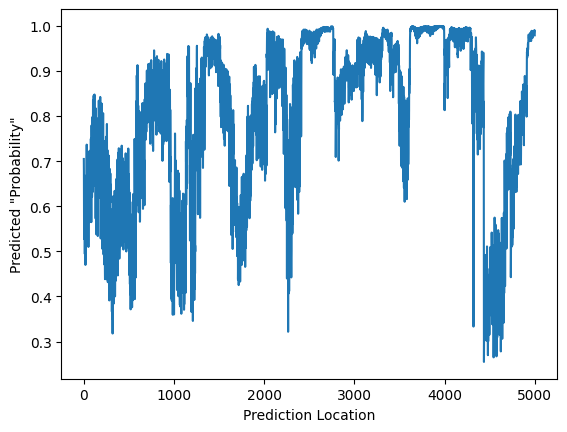

In [179]:
# Load a sequence from a csv

#data_fn = 'data/mesmlr/reprocessed-neg.eventalign.signal.csv'
data_fn = 'data/mesmlr/reprocessed-pos.eventalign.signal.csv'
sequence = load_csv(data_fn, min_val=50, max_val=130, max_sequences=1)[0]
print(sequence[:10])
sequence_tensor = torch.tensor(sequence)
print(sequence_tensor[:10])

# Make predictions on subsequences of length 400
predictions = []
input_len = 400
n_predictions = 5000
input_tensor = torch.zeros((1, 1, 400)).to(device)
for i in tqdm(range(n_predictions)):
    # Could also batch these to speed up predictions
    input_tensor[:, :, :] = sequence_tensor[i:i+input_len]
    prediction = model(input_tensor).sigmoid().item()
    predictions.append(prediction)
    
# Plot predictions
plt.plot(predictions)
plt.xlabel('Prediction Location')
plt.ylabel('Predicted "Probability"')

## Load full validation dataset

In [ ]:
batch_size = 256

neg_fn = 'data/mesmlr/reprocessed-neg.eventalign.signal.csv'
pos_fn = 'data/mesmlr/reprocessed-pos.eventalign.signal.csv'

min_val = 50 # Used to clip outliers
max_val = 130 # Used to clip outliers

seq_len = 400

print("Preparing unmodified...")
print("Loading csv...")
unmodified_sequences = load_csv(neg_fn,
                                min_val=min_val,
                                max_val=max_val,
                                max_sequences=None)
print("Creating sample map...")
unmodified_sample_map = create_sample_map(unmodified_sequences,
                                          seq_len=seq_len)

print("Creating splits...")
unmodified_train, unmodified_val, unmodified_test = create_splits(
        unmodified_sequences, unmodified_sample_map, seq_len=seq_len, shuffle=False)
print("Prepared.")

print("Preparing modified...")
print("Loading csv...")
modified_sequences = load_csv(pos_fn,
                              min_val=min_val,
                              max_val=max_val,
                              max_sequences=None)
print("Creating sample map...")
modified_sample_map = create_sample_map(modified_sequences,
                                        seq_len=seq_len)
print("Creating splits...")
modified_train, modified_val, modified_test = create_splits(
        modified_sequences, modified_sample_map, seq_len=seq_len, shuffle=False)
print("Prepared.")

val_dataset = NanoporeDataset(unmodified_sequences,
                              unmodified_val,
                              modified_sequences,
                              modified_val,
                              device=device,
                              synthetic=False,
                              seq_len=seq_len)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

## Make predictions on full validation dataset

In [ ]:
model.to(device)

with torch.no_grad():
    seq_preds = {}
    dataloader_idx = 0
    for sample, label in tqdm(val_dataloader):
        sample.to(device)
        pred = model(sample).sigmoid()
        for i in range(len(pred)):
            seq_idx = val_dataset.get_seq_idx(dataloader_idx)
            dataloader_idx += 1
            seq_label = label[i].item()
            seq_id = (seq_label, seq_idx)
            if seq_id not in seq_preds:
                seq_preds[seq_id] = []
            seq_preds[seq_id].append(pred[i].item())

  3%|███                                                                                       | 3617/105941 [05:47<2:41:56, 10.53it/s]

## Analyze predictions

In [149]:
# Compute summary performance statistics

correct = {0: 0, 1: 0}
total = {0: 0, 1: 0}

for seq_id in tqdm(seq_preds):
    label = seq_id[0]
    pred_arr = np.round(np.array(seq_preds[seq_id]))
    if label == 0:
        label_arr = np.zeros(len(pred_arr))
    else:
        label_arr = np.ones(len(pred_arr))
    correct_arr = (pred_arr == label_arr)
    correct[label] += np.sum(correct_arr)
    total[label] += len(pred_arr)

accuracy = (correct[0] + correct[1]) / float(total[0] + total[1])  

true_negatives = correct[0]
true_positives = correct[1]
false_negatives = total[1] - correct[1]
false_positives = total[0] - correct[0]

precision = true_positives / float(true_positives + false_positives)
recall = true_positives / float(true_positives + false_negatives)

print("True negatives:", true_negatives)
print("True positives:", true_positives)
print("False negatives:", false_negatives)
print("False positives:", false_positives)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:01<00:00, 303.25it/s]

True negatives: 10850520
True positives: 9850911
False negatives: 3739465
False positives: 2679965
Accuracy: 0.7633028685925568
Precision: 0.7861310733583191
Recall: 0.7248446253436991


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:03<00:00, 138.42it/s]


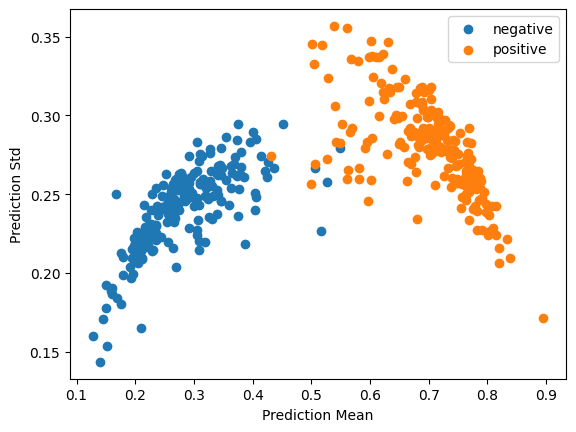

In [127]:
# Plot prediction mean and std for each validation sequence

seq_means = {0: [], 1: []}
seq_stds = {0: [], 1: []}
for seq_id in tqdm(seq_preds):
    label = seq_id[0]
    seq_means[label].append(np.mean(seq_preds[seq_id]))
    seq_stds[label].append(np.std(seq_preds[seq_id]))
plt.scatter(seq_means[0], seq_stds[0], label='negative')
plt.scatter(seq_means[1], seq_stds[1], label='positive')
plt.legend()
plt.xlabel('Prediction Mean')
plt.ylabel('Prediction Std')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:01<00:00, 306.25it/s]


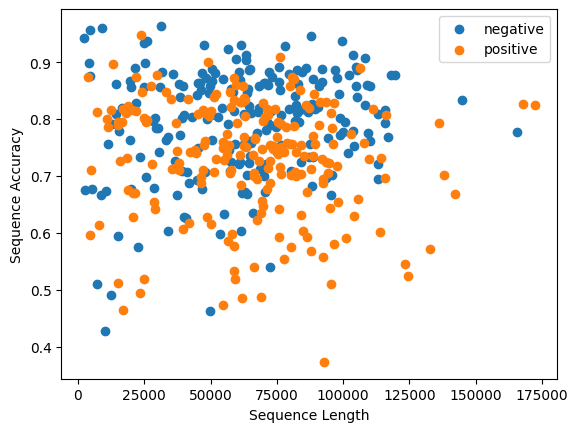

In [128]:
# Plot accuracy by sequence length for each sequence in validation set

seq_lens = {0: [], 1: []}
seq_accs = {0: [], 1: []}
for seq_id in tqdm(seq_preds):
    seq_len = len(seq_preds[seq_id])
    label = seq_id[0]
    if label == 0:
        label_arr = np.zeros(seq_len)
    else:
        label_arr = np.ones(seq_len)
    pred_arr = np.round(np.array(seq_preds[seq_id]))
    correct_arr = (pred_arr == label_arr)
    correct = np.sum(correct_arr)
    seq_acc = float(correct) / seq_len
    seq_lens[label].append(seq_len)
    seq_accs[label].append(seq_acc)
plt.scatter(seq_lens[0], seq_accs[0], label='negative')
plt.scatter(seq_lens[1], seq_accs[1], label='positive')
plt.legend()
plt.xlabel('Sequence Length')
plt.ylabel('Sequence Accuracy')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:00<00:00, 5311.36it/s]


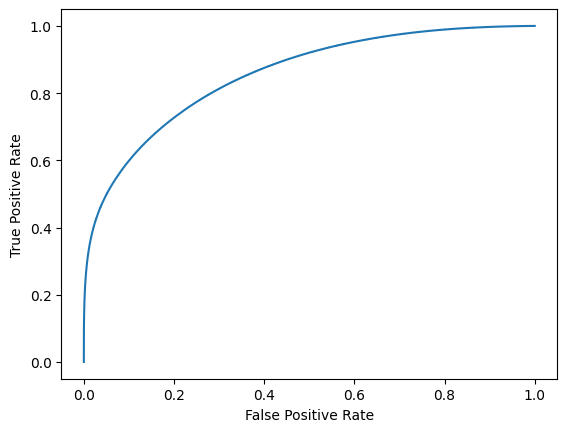

In [152]:
# Compute ROC curve
from sklearn.metrics import roc_curve

pred_list = []
label_list = []
for seq_id in tqdm(seq_preds):
    seq_len = len(seq_preds[seq_id])
    label = seq_id[0]
    preds = seq_preds[seq_id]
    if label == 0:
        labels = np.zeros(seq_len)
    else:
        labels = np.ones(seq_len)
    pred_list.append(preds)
    label_list.append(labels)
    
pred_cat = np.concatenate(pred_list)
label_cat = np.concatenate(label_list)

fpr, tpr, thresholds = roc_curve(label_cat, pred_cat)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Plot training dynamics

       train_loss    val_loss   train_acc     val_acc
count  130.000000  130.000000  130.000000  130.000000
mean     0.006827    0.007752    0.782253    0.749897
std      0.001095    0.000544    0.047557    0.028251
min      0.005924    0.007343    0.581746    0.608298
25%      0.006014    0.007448    0.758562    0.744896
50%      0.006165    0.007496    0.810010    0.764337
75%      0.007474    0.007796    0.815790    0.765840
max      0.010512    0.010228    0.819836    0.770339


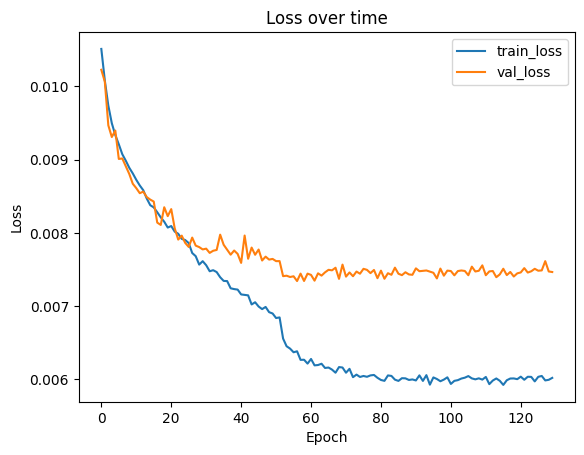

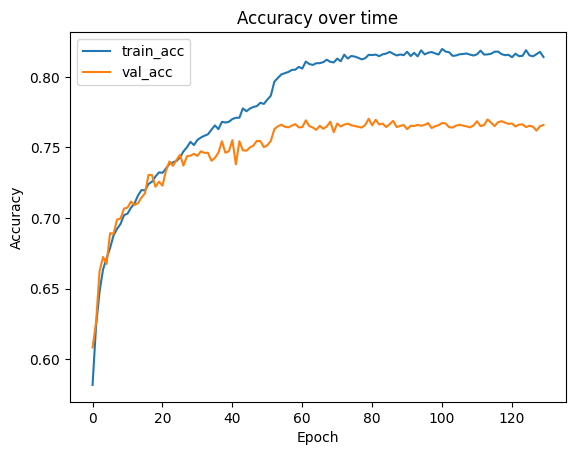

In [175]:
import pandas as pd

training_df = pd.read_csv('results/resnet1d_mesmlr.csv', index_col=0)

print(training_df.describe())

training_df[['train_loss', 'val_loss']].plot()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss over time")
plt.show()

training_df[['train_acc', 'val_acc']].plot()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Accuracy over time")
plt.show()